# Assignment 2:

In this assignment, you are going to solve three problems: 

1. Improving Nearest Neighbors Retrieval Speed (8 points)
2. Gaussian Naive Bayes (4 points)
3. PCA (3 points)

## 1. Improving Nearest Neighbors Retrieval Speed (8 points)

You are given a dataset of coordinates and information about places around the globe. Explore the dataset. You will be mostly working with 2d vectors which represent longitude and latitude.

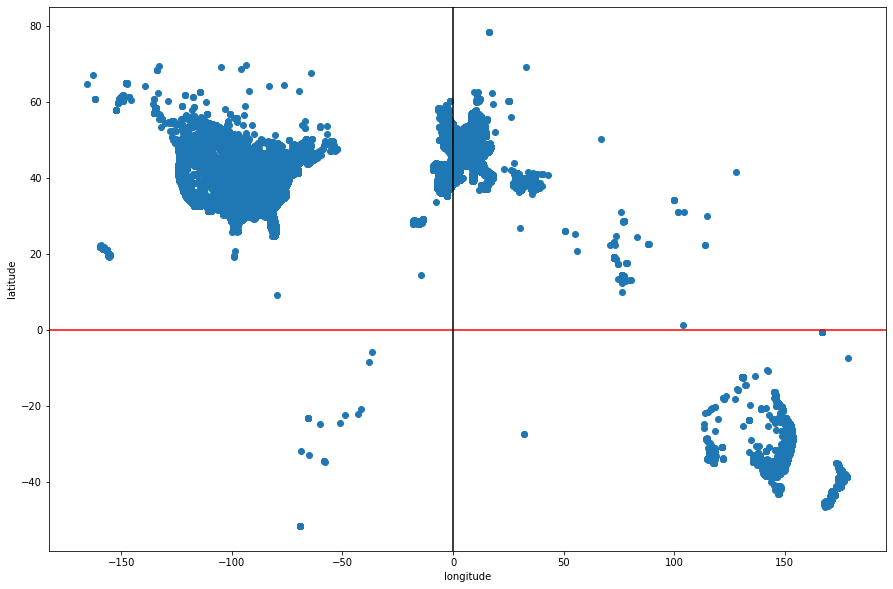

In [332]:
import pickle
import matplotlib.pyplot as plt

with open("poi_sample001.pickle", "rb") as f:
    dataset = pickle.load(f)
    
X = [v[0][0] for v in dataset]
Y = [v[0][1] for v in dataset]

plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.show()

### 1.1 Simple NN Search

Implement the simplest form of NN search (exhaustive search).
Your function should: 
1. Calculate the distance between the test point and each dataset point using euclidean distance.
2. Sort the dataset according to calculated distance in ascending order.
3. Return the top K points from the sorted dataset.

You need to implement this from scratch. Don't use library solutions. 
It is okay to use library function for eucliden distance.

In [333]:
import numpy as np

def simple_nns(v, data, k):
    """
    param: v: test point
    param: data: dataset
    param: k: number of nearest neighbors to retrive
    return: list of nearest points from the dataset
    """
    # implement simple NN Search
    # list of distances for each point from dataset and test point
    distances = []
    # make dataset numpy array
    dataset = np.array(data)
  
    # for each point's coordinate from dataset 
    # calculate euclidian distance with test point
    for point in dataset[:, 0]:
        dist = 0
        
        # going through all dimensions of the points
        for i in range(min(len(v), len(point))):
            # add distance between one component to the overall distance
            dist += (v[i] - point[i]) * (v[i] - point[i])
            
        # taking the square root of overall distance between two points 
        dist = np.sqrt(dist)
        # add that distance to the list of distances
        distances.append(dist)
    
    # sort the data according to distances: from smallest to highest
    sorted_data = dataset[np.argsort(distances)]   
    
    # return first k data points
    return sorted_data[:k]

Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

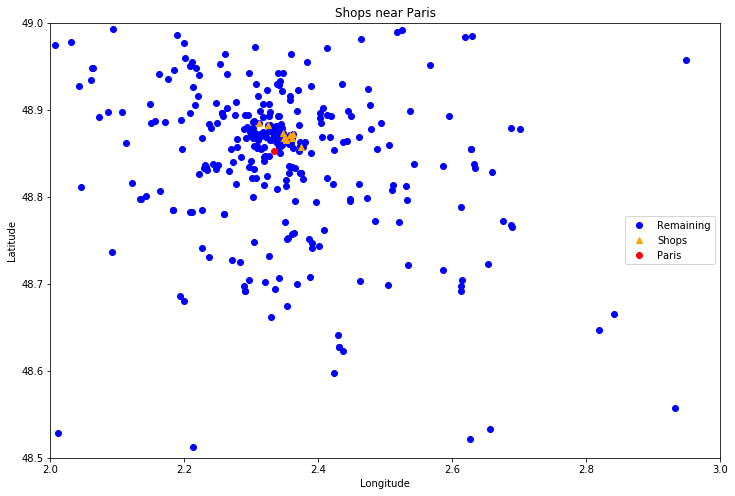

In [334]:
paris = [2.334083, 48.853260]

# find and plot the nearest neighbors according to the above instructions
# Find the first 100 nearest neighbors of Paris.
paris_nn = simple_nns(paris, dataset, 100)

# we are only interested in shops. Filter out everything 
# that doesn't contain 'Shop' substring in the description
paris_nn_shops = np.array([neighbor for neighbor in paris_nn if 'Shop' in neighbor[1]])

plt.figure(figsize=(12, 8))

# plot remaining points
plt.plot(X, Y, 'o', color='blue', label='Remaining')

# plot only shops out of 100 nearest neighbors of Paris
plt.plot([x[0] for x in paris_nn_shops[:, 0]], [x[1] for x in paris_nn_shops[:, 0]],
         '^', color='orange', label='Shops')

# plot Paris coordinates
plt.plot(paris[0], paris[1], 'o', color='red', label='Paris')

plt.title('Shops near Paris')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='center right')

# axes limits are set for better visualization, don't change them
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.show()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

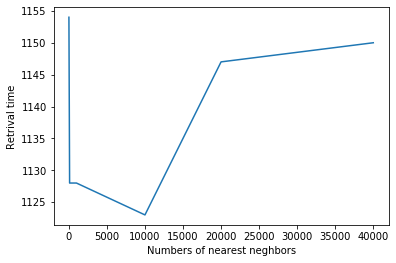

In [335]:
import time
import random

# numbers of nearest neghbors to retrieve
nns = [10, 100, 1000, 10000, 20000, 40000]

# list of retrieval times for every given number of nearest neighbors
simple_times = []

# lambda function for getting current time in milliseconds
# source https://stackoverflow.com/questions/5998245/get-current-time-in-milliseconds-in-python
current_milli_time = lambda: int(round(time.time() * 1000))

# measure retrival time for every value above and save it somewhere 
for nn in nns:
    # select random point's coordinates from the dataset
    random_point = random.choice(dataset)[0]
    
    # save start time
    start_time = current_milli_time()
    
    # find nn neighbors to random point using simple_nns
    simple_nns(random_point, dataset, nn)
    
    # save retrieval time to times list
    simple_times.append((current_milli_time() - start_time))

# plot the results
plt.plot(nns, simple_times)
plt.xlabel('Numbers of nearest neghbors')
plt.ylabel('Retrival time')
plt.show()

What do you observe? Do you see any trends, how can you explain them?

<span style="color:blue"> Your answer: No any trends, time are almost the same, the difference is $10^{-2}$. Brute force query time is largely unaffected by the value of k, because it calculates all distances first, then sorts all data points and then returns first k neighbors. So, retrieval time doesn't depend on number of neighbors, it always calculates everything.</span>

### 1.2 Improving NNS

Choose any method you like to speed up NN search, understand it thoroughly and learn how to apply it. Explain the way it works in few sentences and in your own words.

<span style="color:blue"> Your answer: I have found 2 sklearn built in methods: NNS based on Ball Tree and KD Tree. I have chosen the second one, the reason is that KD Tree based NNS is more applicable for 2 dimensional data rather than Ball Tree according to https://towardsdatascience.com/tree-algorithms-explained-ball-tree-algorithm-vs-kd-tree-vs-brute-force-9746debcd940. KD Tree is an NN approximation technique which consists of two crutial steps:
    <br/>1) It takes random from d axis of the data
    <br/>2) It splits the data by the median of the data projection on this axis
    <br/> This process is repeated several times.
</span>

In [336]:
# apply the chosen method
from sklearn.neighbors import NearestNeighbors, KDTree
from annoy import AnnoyIndex

# take only coordinates of the dataset
KD_data = np.array([[v[0][0],v[0][1]] for v in dataset])

# create KDTree using euclidian distance as metric
tree = KDTree(KD_data, metric='euclidean')

annoy = AnnoyIndex(2, metric='euclidean')

def improved_nns(v, data, k):
    """
    param: v: test point
    param: data: dataset
    param: k: number of nearest neighbors to retrive
    return: list of nearest points from the dataset
    """
    v = np.array(v)
    print(v.shape)
    # taking only coordinates from the data
    dataset = np.array([[d[0][0],d[0][1]] for d in data])
    annoy.add_item(0, v)
    for i, v1 in zip(range(1, len(dataset) + 1), dataset):
        annoy.add_item(i, v1)  
    
    annoy.build(20)
    # query k nearest neighbors from the test point
#     dists, inds = tree.query(v, k=k)
#     dists, inds = lshf.kneighbors(v, n_neighbors=k)
    inds = annoy.get_nns_by_vector(v, k, include_distances=False)
    #print(inds)
    # find data points from the dataset according 
    # to the indeces that algorithm returned
    k_neighbors = [data[ind] for ind in inds]
    
#     print(k_neighbors)
    return k_neighbors

Apply the chosen method on the geographic dataset. Similarly to the above, find the nearest neighbors and plot retrieval times.

In [337]:
# apply the chosen method
from sklearn.neighbors import NearestNeighbors, KDTree

# take only coordinates of the dataset
KD_data = np.array([[v[0][0],v[0][1]] for v in dataset])

# create KDTree using euclidian distance as metric
tree = KDTree(KD_data, metric='euclidean')

def improved_nns(v, data, k):
    """
    param: v: test point
    param: data: dataset
    param: k: number of nearest neighbors to retrive
    return: list of nearest points from the dataset
    """
    v = np.array(v).reshape(1, -1)
    
    # taking only coordinates from the data
    dataset = np.array([[d[0][0],d[0][1]] for d in data])
    
    # query k nearest neighbors from the test point
    dists, inds = tree.query(v, k=k)
    
    # find data points from the dataset according 
    # to the indeces that algorithm returned
    k_neighbors = [data[ind] for ind in inds[0]]
    
    return k_neighbors

Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

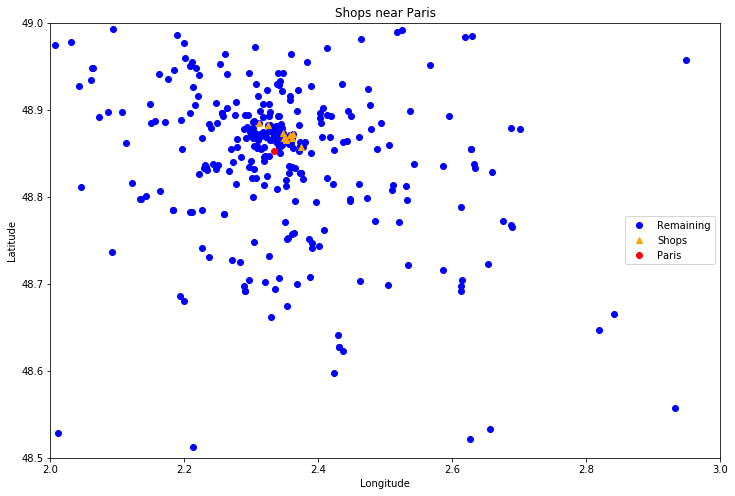

In [338]:
paris = [2.334083, 48.853260]

# find and plot the nearest neighbors according to the above instructions
# Find the first 100 nearest neighbors of Paris.
paris_nn = improved_nns(paris, dataset, 100)


# we are only interested in shops. Filter out everything 
# that doesn't contain 'Shop' substring in the description
paris_nn_shops = np.array([neighbor for neighbor in paris_nn if 'Shop' in neighbor[1]])

x = [v[0] for v in paris_nn_shops[:,0]]
y = [v[1] for v in paris_nn_shops[:,0]]
plt.figure(figsize=(12, 8))
# plot remaining points
plt.plot(X, Y, 'o', color='blue', label='Remaining')

# plot only shops out of 100 nearest neighbors of Paris
plt.plot(x, y,
         '^', color='orange', label='Shops')

# plot Paris coordinates
plt.plot(paris[0], paris[1], 'o', color='red', label='Paris')

plt.title('Shops near Paris')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='center right')

# axes limits are set for better visualization, don't change them
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.show()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

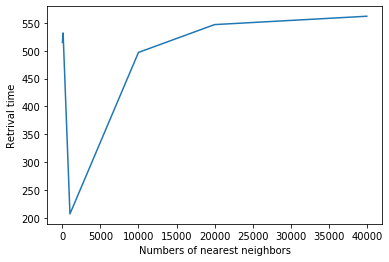

In [369]:
# numbers of nearest neghbors to retrieve
nns = [10, 100, 1000, 10000, 20000, 40000]

# list of retrieval times for every given number of nearest neighbors
improved_times = []

# measure retrival time for every value above and save it somewhere 
for nn in nns:
    # select random point's coordinates from the dataset
    random_point = random.choice(dataset)[0]
    
    # save start time
    start_time = current_milli_time()
    
    # find nn neighbors to random point using simple_nns
    improved_nns(random_point, dataset, nn)
    
    # save retrieval time to times list
    improved_times.append((current_milli_time() - start_time))

# plot the results
plt.plot(nns, improved_times)
plt.xlabel('Numbers of nearest neighbors')
plt.ylabel('Retrival time')
plt.show()

What do you observe? Do you see any trends, how can you explain them?

<span style="color:blue"> Your answer: Time slightly increases as k increases. It's because of nature of KD Tree. The search there is implemented in logarithmic way. That's why it's log(N), where N-number of neighbors.</span>

### 1.3 Comparison

Plot retrieval times together in the same plot. If time difference is big (as it should be), use a logarithmic scale for better visualization. If you don't achieve any time improvements, then you are doing something wrong.

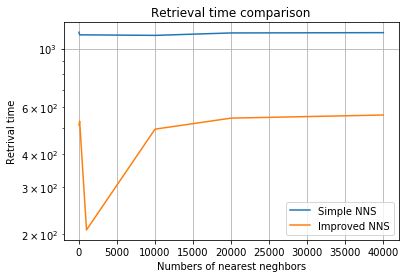

In [370]:
# plot retrieval times together
plt.plot(nns, simple_times, label='Simple NNS')
plt.plot(nns, improved_times, label='Improved NNS')
plt.title('Retrieval time comparison')
plt.xlabel('Numbers of nearest neghbors')
plt.ylabel('Retrival time')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

Analyze the results and summarise them here. 

<span style="color:blue"> Your answer: As we can see simple NNS is slower than improved one. Also simple NNS doesn't depend on the number of neighbors, while improved one depends, it's because of search in the tree: log(N), where N-number of queried neighbors. That's why simple NNS is straight line and improved one is linearly growing.</span>

## 2. Gaussian Naive Bayes (4 points)

Finish the implementation of Gaussian NB.
https://towardsdatascience.com/implementing-naive-bayes-in-2-minutes-with-python-3ecd788803fe

In [341]:
from math import exp, sqrt, pi, log
class GaussianNB:
    def fit(self, X_train, y_train):
        """
        fit classifier, i.e. calculate needed statistics
        """
        ### START CODE HERE ###
        df = pd.DataFrame(X_train)
        df['y'] = y_train
        self.prior = df.groupby('y').apply(lambda x: len(x) / X_train.shape[0])
        self.means = df.groupby('y').apply(np.mean)
        self.std = df.groupby('y').apply(np.std)
        
        ### END CODE HERE ###
    
    def calculate_probability(self, x, mean, stdev):
        """
        calculates that point belongs to some class
        param: x: test point
        param: mean: mean of some class
        param: stdev: stdev of some class
        return: the probability that test point belongs to some class
        """
        exponent = exp(-((x - mean) ** 2 / (2 * (stdev ** 2))))
        probability = (1 / (sqrt(2 * pi) * stdev)) * exponent
        return probability
        
    def predict(self, X_test):
        """
        predict class labels for test data points
        param: test_data: list of data points to be classified
        return: predictions (class labels)
        """
        ### START CODE HERE ###
        # list of predictions
        unique_classes = set(y_train)
        # dictionary with class probabilities
        predictions = dict.fromkeys(unique_classes)
        
        for x in X_test:
            for cl in unique_classes:
                # initialize probability of the class by log of prior
                if not predictions[cl]:
                    predictions[cl] = []
                pred = log(self.prior[cl])
                for i in range(len(self.means)):
                    # sum logs of probabity
                    pred += log(self.calculate_probability(x[i], self.means.iloc[cl,i], self.std.iloc[cl,i]))
                predictions[cl].append(pred)
        
        predictions = pd.DataFrame(predictions)
        # get maximum argument in each prediction of the class
        predictions = np.array(predictions.idxmax(axis=1))

        ### END CODE HERE ###
        
        return predictions

In [342]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
import pandas as pd
from scipy.stats import norm

iris = load_iris()
# X, y, column_names = iris['data'], iris['target'], iris['feature_names']
# X = pd.DataFrame(X, columns=column_names)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# print(X_train)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)


# You should get the accuracy score not less than 90%.
print(accuracy_score(y_test, y_pred))

0.9333333333333333


## 3. PCA

Apply PCA to the Digits dataset, produce the scree plot for the given data and decide the optimal number of PCs to keep. Calculate and print their total explained variance.

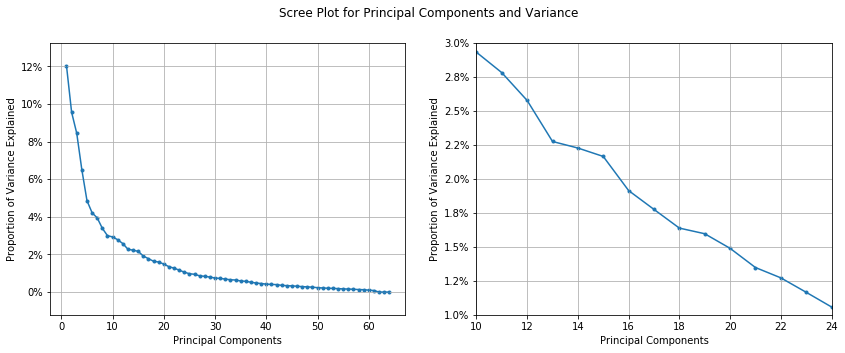

Total explained variance for PCs=16: 72.81119995335413%


In [343]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter

X, y = load_digits(return_X_y=True)

# scaling features because of features can have 
# different variances due to the measure scale.
# If one component will vary less than another,
# PCA might determine the direction of maximal 
# variance more closely to one axis.
# I have chosen StandardScaler because it standardizes
# the dataset’s features onto unit scale (mean = 0 and variance = 1) 
# which is used as a requirement for the optimal performance 
# in many machine learning algorithms. 
# Robust scaler and Min-Max Scaler are not applicable in this task
# because they can still preserve one feature's perfection
X_scaled = StandardScaler().fit_transform(X)

# apply PCA
pca = PCA()
X_PCA = pca.fit(X_scaled)

# make scree plot

# Ys and Xs for the plot
explained_variance = pca.explained_variance_ratio_
n_of_comps = [i for i in range(1, len(explained_variance) + 1)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Scree Plot for Principal Components and Variance')

# draw whole plot
ax1.scatter(n_of_comps, explained_variance, marker='.')
ax1.plot(n_of_comps, explained_variance)
# source of how I plot Ys in percentage format
# https://stackoverflow.com/questions/31357611/format-y-axis-as-percent
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.grid(True)

# enlarged graph for finding out the most optimal number of PCs
ax2.scatter(n_of_comps, explained_variance, marker='.')
ax2.plot(n_of_comps, explained_variance)
# source of how I plot Ys in percentage format
# https://stackoverflow.com/questions/31357611/format-y-axis-as-percent
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
ax2.set_xlabel('Principal Components')
ax2.set_ylabel('Proportion of Variance Explained')
ax2.set_xlim([10, 24])
ax2.set_ylim([0.01, 0.03])
ax2.grid(True)
plt.show()

# choose the number of PCs and calculate and print their total explained variance
pca_result = PCA(n_components=16)
pca_result.fit(X_scaled)
print(f'Total explained variance for PCs=16: {sum(pca_result.explained_variance_ratio_)*100}%')

Thoroughly justify your choice - this is the main part of the work for this task.

<span style="color:blue"> Your answer: I have apllied "elbow method" and decided to check range from 10 to 24 on the enlarged graph to find optimal number of components to keep. After 16th component the graph goes linear, so I have chosen 16 Principal components to keep. I have calculated the total variance for PCs=16 and it equals ~ 73% </span>